![](https://brandingmonitor.pl/wp-content/uploads/2019/01/new-rebranding-sgh-nowe-logo.png)

Szkoła Główna Handlowa w Warszawie

Optymalizacja składki ubezpieczeniowej PiTU S.A.

234060-0723 Zaawansowane modelowanie symulacyjne

- Uladzislau Darhevich 108519

# Podsumowanie

Żeby prawdopodobieństwo ruiny było mniejsze niż 0.01, składka powinna być ustalona na poziomie 1400 zł. Przy określonej wartości nadwyżki równej 10000 zł, składka, ustalona na poziomie 1400 zł, będzie wystarczająca, żeby prawdopodobieństwo ruiny było mniejsze, niż 0.01. Poprzez zwiększenie wielkości nadwyżki możliwe jest zmniejszenie składki przy zachowaniu danego poziomu prawdopodobieństwa upadłości. Tak jeżeli zwiększyć rozmiar nadwyżki do 40000 zł, składka na poziomie 1100 zł będzie wystarczająca. Kiedy nadwyżka końcowa będzie równa początkowej (10000 zł), to zależność pomiędzy prawdopodobieństwem bankructwa $pb$ i wysokością skladki $sk$ można opisać formulą: $pb = 0.9314 - 0.00074 \cdot sk$. Powiększenie liczb symulacji zmniejsza odchylenie standardowe i przedziały ufności, ale zwiększa czas symulacji.

# Opis organizacji

PiTU S.A. - przedsiębiorstwo ubezpieczeniowe, spółka akcyjna działająca w Polsce. Spółka sprzeda ubezpieczenia odpowiedzialności cywilnej dla osób fizycznych.

# Opis problemu

Prezes zarządu zakładu ubezpieczeń PiTU S.A., Marcin R., zasłyszał, że Prezydent planuje naturalizować wszystkich chętnych z Dżydżykistanu. Mieszkańcy Dżydżykistanu znani są z bardzo agresywnego stylu jazdy. Prawdopodobieństwo, że taki kierowca ulegnie wypadkowi jest znacznie wyższe. Konieczne jest ponowne rozważenie wysokości składki, która obecnie wynosi 500 zł, aby spółka nie zbankrutowała.

In [206]:
import csv
import scipy as sc
import scipy.stats
import numpy as np
from math import exp, factorial
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.stats import kstest
plt.style.use('seaborn-whitegrid')
import pandas as pd

Liczba szkód dobrze opisuje rozkład Poissona, natomiast wielkość szkód – rozkład log-normalny. Oczekiwana liczba klientów – 100 – oraz aktualną nadwyżka 10 000 zł.

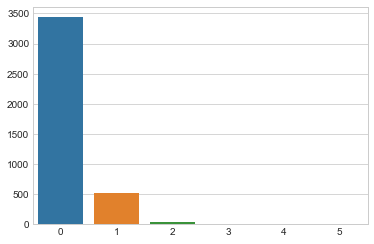

In [207]:
liczba_szkod = {0: 3437,
                1: 522,
                2: 40,
                3: 2,
                4: 0,
                5: 0}

sns.barplot(x=list(liczba_szkod.keys()),
            y=list(liczba_szkod.values()));

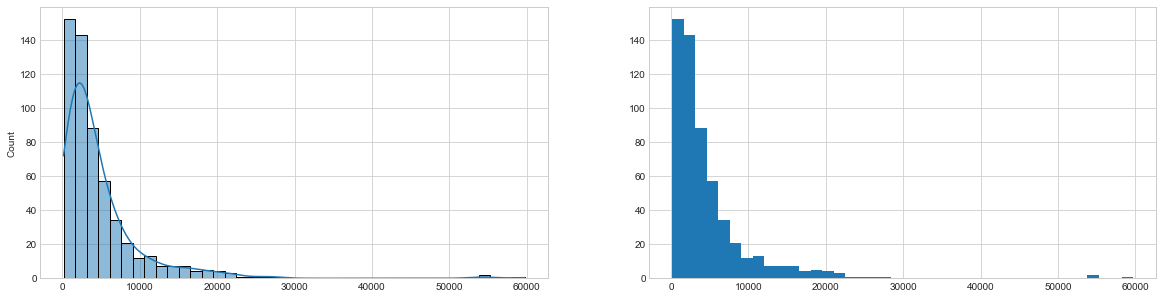

In [225]:
# szkody = []
# with open('../data/data_asm/szkody.txt', 'r') as csvfile:
#     reader = csv.reader(csvfile, delimiter=";")
#     for row in reader:
#         szkody.append(int(row[1]))
# # Średnia liczba szkód
# liczba_polis = sum(liczba_szkod.values())
# srednia_liczba_szkod = (sum([x * y for x, y in liczba_szkod.items()]) /
#                         liczba_polis)

# # Czy liczba szkód ma faktycznie rozkład Poissona?
# poisson_test = [sc.stats.poisson.pmf(i, srednia_liczba_szkod) *
#                 liczba_polis for i in range(len(liczba_szkod))]
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 5])
# sns.histplot(szkody, bins=40, kde=True, ax=ax1)
# ax2 = plt.hist(szkody, bins=40)
# plt.show()

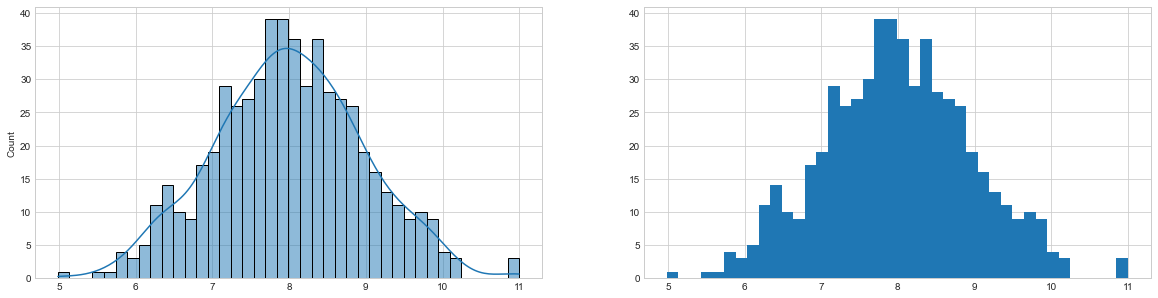

In [209]:
szkody_ln = np.log(szkody)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 5])
sns.histplot(szkody_ln, bins=40, kde=True,ax=ax1)
ax2 = plt.hist(szkody_ln, bins=40)
plt.show()

In [210]:
# Test chi-kwadrat z biblioteki scipy pomoże odpowiedziec na pytanie
test1 = sc.stats.chisquare(list(liczba_szkod.values()), f_exp=poisson_test)
if test1[1] > 0.05:
    print("p-value wyniosło:", round(test1[1], 4),
          "Brak podstaw do odrzucenia hipotezy zerowej")
else:
    print("Należy odrzucic hipoteze zerowa")


p-value wyniosło: 0.9999 Brak podstaw do odrzucenia hipotezy zerowej


In [211]:
test2 = kstest(szkody_ln, sc.stats.norm.cdf,
               args=(np.mean(szkody_ln), np.std(szkody_ln)))
if test2[1] > 0.05:
    print("p-value wyniosło:", round(test2[1], 4),
          "- brak więc podstaw do odrzucenia hipotezy " +
          "o log-normalności rozkładu zmiennej")
else:
    print("należy odrzucic hipotezę zerowa")
# Parametry wielkości szkód potrzebne do symulacji
SR_SZKODA_LN = np.mean(szkody_ln)
STD_SZKODA_LN = np.std(szkody_ln)

p-value wyniosło: 0.9974 - brak więc podstaw do odrzucenia hipotezy o log-normalności rozkładu zmiennej


# Wyniki analizy

Model simulacyjny


In [212]:
def model(liczba_klientow, srednia_liczba_szkod,
          sr_szkoda_ln, std_szkoda_ln, horyzont,
          nadwyzka, skladka, seed=-1):

    seed == -1 or sc.random.seed(seed)

    # Definiujemy daty umów klientow w symulacji
    daty_umow = [sc.random.randint(0, 364) for i in range(liczba_klientow)]
    kalendarz_wplat = [0]*365
    for dataUmowy in daty_umow:
        kalendarz_wplat[dataUmowy] += 1

    # Liczymy liczbę szkód przypadających na jednego klienta
    liczba_szkod_klienta = sc.random.poisson(srednia_liczba_szkod,
                                             liczba_klientow)

    # i ustalamy daty wyplaty dla wszystkich polis
    kalendarz_wyplat = [0]*(365*horyzont)
    for k in range(liczba_klientow):
        for s in range(liczba_szkod_klienta[k]):
            data_wyplaty = sc.random.randint(daty_umow[k], horyzont*365)
            kalendarz_wyplat[data_wyplaty] += 1

    # Analiza wyników firmy dla danego horyzontu czasowego i danych szkód:
    for dzien in range(365*horyzont):
        if dzien <= 364:
            nadwyzka += kalendarz_wplat[dzien] * skladka
        liczba_wyplat = kalendarz_wyplat[dzien]
        odszkodowania = 0
        if liczba_wyplat > 0:
            odszkodowania = sum(np.exp(sc.random.normal(sr_szkoda_ln,
                                                           std_szkoda_ln,
                                                           liczba_wyplat)))
        if nadwyzka < odszkodowania:
            return nadwyzka - odszkodowania
        
        nadwyzka -= odszkodowania
        
    return nadwyzka

Funkcja wywołująca symulację n razy

In [213]:
def wywolanie(nadwyzka, skladka, liczba_powtorzen,
              liczba_klientow, srednia_liczba_szkod,
              sr_szkoda_ln, std_szkoda_ln, horyzont):
    wynik = []
    bankructwo = 0
    wynik_dodatni = []
    for seed in range(liczba_powtorzen):
        wynik.append(model(liczba_klientow, srednia_liczba_szkod,
                           sr_szkoda_ln, std_szkoda_ln, horyzont,
                           nadwyzka, skladka, seed))
        if wynik[seed] < 0:
            bankructwo += 1
        if wynik[seed] > 0:
            wynik_dodatni.append(wynik[seed])
    sredni_wynik = np.mean(wynik_dodatni)
    prawd_bankr = bankructwo / liczba_powtorzen
    return [bankructwo, prawd_bankr, sredni_wynik]

Przeprowadzenie symulacji

In [214]:
# Zmienne i parametry w modelu:
sr_wynik = []  # Średni wynik finansowy firmy
wysokosc_skladki = []
prawd_bankr = []
liczba_ruin = []

LICZBA_POWTORZEN = 100
LICZBA_KLIENTOW = 100
HORYZONT = 2  # Długość obowiązywania umowy - zakładamy 2 lata

results = pd.DataFrame() #dane symulacyjne zbierają się do datafram'u

for nadwyzka in range(10000, 50000, 10000):
    prawd_bankr = []
    wysokosc_skladki = []
    for skladka in range(500, 1500, 100):
        wartosc_f_xy = wywolanie(nadwyzka, skladka,
                                 LICZBA_POWTORZEN, LICZBA_KLIENTOW,
                                 srednia_liczba_szkod, SR_SZKODA_LN,
                                 STD_SZKODA_LN, HORYZONT)
        wysokosc_skladki.append(skladka)
        liczba_ruin.append(wartosc_f_xy[0])
        prawd_bankr.append(wartosc_f_xy[1])
        sr_wynik.append(wartosc_f_xy[2])
#         print("Nadwyżka: ", nadwyzka, "Składka: ", skladka,
#               "Liczba ruin: ", wartosc_f_xy[0], "Średni wynik: ",
#               round(wartosc_f_xy[2]), "Prawd_bankr: ", wartosc_f_xy[1])
        
    results[nadwyzka] = prawd_bankr
    results.index = wysokosc_skladki

Z danych historycznych wiadomo, że liczbę szkód dobrze opisuje rozkład Poissona, natomiast wielkość  szkód – rozkład log-normalny. Do symulacji przyjęta oczekiwana liczba klientów – 100 – oraz aktualna nadwyżka - 10 000 zł. Długość obowiązywania umowy - 2 lata. Początkowo przyjmuje się, że liczba symulacji dla każdej wielkości składki wynosi 100 razy. Bankructwo występuje w ten moment, kiedy bilans PITU S.A. jest ujemny. Stosunek liczby bankructw do liczby symulacji jest średnim prawdopodobieństwem ruiny. Przy obecnej wielkości nadwyżki (10000 zł) i składki (500 zł) prawdopodobieństwo bankructwa wynosi ~ 66%. Można zatem stwierdzić, że obecna wysokość składki z dużym prawdopodobieństwem doprowadzi do ruiny. Przeprowadzano symulacje dalej i zwiększono wartość składki o 100 zł. Z wyników widać, że razem ze zwiększeniem składki OC prawdopodobieństwo maleje. 
Jeśli dodać do modelu symulacyjnego inną zmienną - wartość nadwyżki, można zauważyć, jak zmieni się prawdopodobieństwo bankructwa w zależności od zmiany składki i nadwyżki. Liczba symulacji oraz horyzont planowania pozostają niezmienione. Wyniki są podane na przedstawionym poniżej rysunku i w tabeli.

In [215]:
results

,10000,20000,30000,40000
500,0.66,0.54,0.39,0.27
600,0.54,0.39,0.27,0.20
700,0.39,0.27,0.21,0.15
800,0.27,0.21,0.15,0.06
900,0.21,0.15,0.06,0.03
1000,0.16,0.06,0.03,0.01
1100,0.06,0.03,0.01,0.00
1200,0.03,0.01,0.00,0.00
1300,0.01,0.00,0.00,0.00
1400,0.00,0.00,0.00,0.00


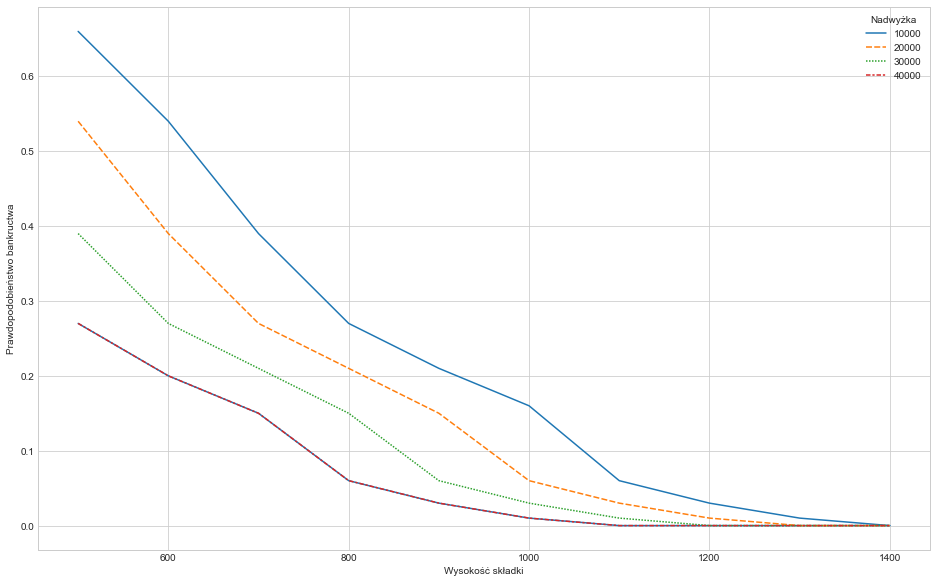

In [216]:
plt.figure(figsize=(16, 10))
plt.plot(wysokosc_skladki, prawd_bankr)
plt.ylabel('Prawdopodobieństwo bankructwa')
plt.xlabel('Wysokość składki')
sns.lineplot(data=results);
plt.legend(title="Nadwyżka")
plt.show();

Dalej badano zależność pomiędzy wysokością składki i prawdopodobieństwem bankructwa przy stałej wielkości nadwyżki 10000 zł

In [217]:
y = results[10000].values
X = results.index.values.reshape(-1, 1)

In [218]:
from sklearn.linear_model import LinearRegression

In [220]:
reg = LinearRegression().fit(X, y)
print('Współczynnik determinacji predykcji R^2= ', reg.score(X, y))
reg.intercept_, reg.coef_

Współczynnik determinacji predykcji R^2=  0.9219606582564338


(0.9313939393939392, array([-0.00073515]))

Wzór na obliczenie zależności pomiędzy prawdopodobieństwem bankructwa $pb$ i wysokością skladki $sk$ przy stałej wielkości nadwyżki 10000 zł:
$$pb = 0.9314 - 0.00074 \cdot sk$$

Dalej badano jak liczba symulacji wpływa na wyniki. W tabeli niżej podano prawdopodobieństwo bankructwa dla różnych liczb symulacji przy wielkości nadwyżki 10000 zł:

In [221]:
%%time
# Zmienne i parametry w modelu:
sr_wynik = []  # Średni wynik finansowy firmy
wysokosc_skladki = []
prawd_bankr = []
liczba_ruin = []

skladka = 10000
LICZBA_KLIENTOW = 100
HORYZONT = 2  # Długość obowiązywania umowy - zakładamy 2 lata

results = pd.DataFrame() #dane symulacyjne zbierają się do datafram'u

for LICZBA_POWTORZEN in [100, 500, 1000, 2000]:
    prawd_bankr = []
    wysokosc_skladki = []
    for skladka in range(500, 1500, 50):
        wartosc_f_xy = wywolanie(nadwyzka, skladka,
                                 LICZBA_POWTORZEN, LICZBA_KLIENTOW,
                                 srednia_liczba_szkod, SR_SZKODA_LN,
                                 STD_SZKODA_LN, HORYZONT)
        wysokosc_skladki.append(skladka)
        liczba_ruin.append(wartosc_f_xy[0])
        prawd_bankr.append(wartosc_f_xy[1])
        sr_wynik.append(wartosc_f_xy[2])
        
    results[LICZBA_POWTORZEN] = prawd_bankr
    results.index = wysokosc_skladki

Wall time: 1min 56s


In [222]:
results.std()

100     0.093318
500     0.079358
1000    0.069544
2000    0.069090
dtype: float64

In [223]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m-h, m+h
results.apply(mean_confidence_interval)

,100,500,1000,2000
0,0.022826,0.029059,0.025152,0.02509
1,0.110174,0.103341,0.090248,0.08976


Z tabeli widać, że powiększenie liczb symulacji zmniejsza odchylenie standardowe i przedziały ufności, ale wydłuża czas obliczeń i wymaga dodatkowych nakładów finansowych.

Wyniki symulacji są zgodne z intuicją i mogą być wdrożone w praktyce.

# Analiza wrażliwości

Można powiedzieć, że zmiana wielkości nadwyżki o 10000 zł spowoduje zmniejszenie wysokości składki o 100 zł. 

# Wnioski i zalecenia

Na podstawie badań firmie PITU S.A. zalecano kilka mozliwych sposób dalszego działania na rynku ubiespeczeń:
- zwiekszyć wielkośc składki do 1400 zł przy zachowaniu rozmiaru nadwyżki 10000 zł;
- zwiekszyć rozmiar nadwyżki do 40000 zł, wtedy można zostawić wielkośc składki na poziomie 1100 zł;
- zwiększyć dopuszczalne prawdopodobieństwo ruiny.

# Bibliografia

- „Optymalizacja portfela szkód” K. Saduś, M. Kwiecień, R. Lipiński oraz „Ubezpieczenia komunikacyjne firmy ABC” A. Kołota, M. Mączyńska 

 